In [1]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString

In [2]:
def read_gdf_from_zip(zip_fp):
    """
    Reads multiple csv files from ZipFile into a Pandas dataframe.
    """
    for zip_file in glob.glob(zip_fp):
        zf = zipfile.ZipFile(zip_file)
        dfs = [pd.read_csv(zf.open(f),sep=",") for f in zf.namelist()]
        sim_df = pd.concat(dfs,ignore_index=True)
    
    return sim_df

In [7]:
snapshot = read_gdf_from_zip('/Users/vsundar/Documents/personal/smc/data/vehicle_data/Simulation_Snapshot/snapshot.zip')

In [8]:
def start_end(sim_df):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    sim_snap_df = sim_df.groupby('VEHICLE')   
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    sim_end.X_COORD = pd.to_numeric(sim_end.X_COORD)
    sim_end.Y_COORD = pd.to_numeric(sim_end.Y_COORD)
    sim_start.X_COORD = pd.to_numeric(sim_start.X_COORD)
    sim_start.Y_COORD = pd.to_numeric(sim_start.Y_COORD)
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    sim_start_wgs84 = sim_start_gdf.to_crs(epsg=4326)
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    sim_end_wgs84 = sim_end_gdf.to_crs(epsg=4326)
    sim_start_wgs84 = sim_start_wgs84.reset_index(drop=True)
    
    return sim_start_wgs84, sim_end_wgs84

In [9]:
import time
start_time = time.time()
sim_start,sim_end = start_end(snapshot)
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.74615502357483 seconds ---


In [10]:
sim_start

,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD,geometry
0,245126,0:00:30,526,0,1,75.0,15.0,0.0,1,24512601,0,447472.067970,4.637343e+06,POINT (-87.63313 41.88627)
1,166155,2:40,57,0,3,112.5,0.0,-30.0,1,16615501,0,447573.359857,4.636864e+06,POINT (-87.63187 41.88196)
2,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,0,446824.617870,4.636856e+06,POINT (-87.64089 41.88185)
3,202723,2:47:30,139,1,3,67.5,7.5,-7.5,1,20272301,0,447741.477250,4.635920e+06,POINT (-87.62976 41.87347)
4,241483,2:47:30,527,0,1,120.0,7.5,7.5,1,24148301,0,447315.850742,4.637344e+06,POINT (-87.63502 41.88627)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107753,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,0,447608.505670,4.634674e+06,POINT (-87.63125 41.86224)
107754,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,0,447605.849683,4.634810e+06,POINT (-87.63130 41.86347)
107755,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,0,447600.676242,4.636580e+06,POINT (-87.63151 41.87941)
107756,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,0,447603.193859,4.634946e+06,POINT (-87.63134 41.86469)


In [57]:
def building_prep(building_map:str):
    """ 
    Reads building geojson and prepares building data for calculating nearest distance metrics.
    """
    building_map = gpd.read_file(building_map)
    building_map = building_map.assign(centroid=building_map.centroid)
    building_map.crs="EPSG:4326"
    building_map = building_map.to_crs(epsg=26916)
    building_map["footprint_area"] = building_map.geometry.area
    ##Calculate relative area to obtain weighted distance measures
#     building_map["relative_area"] = (building_map.footprint_area)/(building_map.footprint_area.sum())
    building_map = building_map.to_crs(epsg=4326)
    
    return building_map

In [156]:
##Reads a building mask
building_map = building_prep(building_map= "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/Building_Footprints/ChicagoLoop_attr.geojson")
building_map_proc = building_map.drop_duplicates(subset='centroid', keep="last")
building_map_proc=building_map_proc.reset_index(drop=True)
building_map_proc['building_id'] = building_map_proc.index
building_map_proc.dtypes


area               float64
perimeter          float64
geometry          geometry
centroid          geometry
footprint_area     float64
building_id          int64
dtype: object

In [93]:
## Read a building mask and clip the agents
building_mask = "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/building_mask/building_mask_buff.shp"
building_mask = gpd.read_file(building_mask)
sim_start_clip = gpd.overlay(sim_start,building_mask)
sim_end_clip = gpd.overlay(sim_end,building_mask)


In [94]:
sim_start_clip

,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD,id,geometry
0,245126,0:00:30,526,0,1,75.0,15.0,0.0,1,24512601,0,447472.067970,4.637343e+06,1,POINT (-87.63313 41.88627)
1,166155,2:40,57,0,3,112.5,0.0,-30.0,1,16615501,0,447573.359857,4.636864e+06,1,POINT (-87.63187 41.88196)
2,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,0,446824.617870,4.636856e+06,1,POINT (-87.64089 41.88185)
3,202723,2:47:30,139,1,3,67.5,7.5,-7.5,1,20272301,0,447741.477250,4.635920e+06,1,POINT (-87.62976 41.87347)
4,241483,2:47:30,527,0,1,120.0,7.5,7.5,1,24148301,0,447315.850742,4.637344e+06,1,POINT (-87.63502 41.88627)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103317,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,0,447608.505670,4.634674e+06,1,POINT (-87.63125 41.86224)
103318,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,0,447605.849683,4.634810e+06,1,POINT (-87.63130 41.86347)
103319,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,0,447600.676242,4.636580e+06,1,POINT (-87.63151 41.87941)
103320,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,0,447603.193859,4.634946e+06,1,POINT (-87.63134 41.86469)


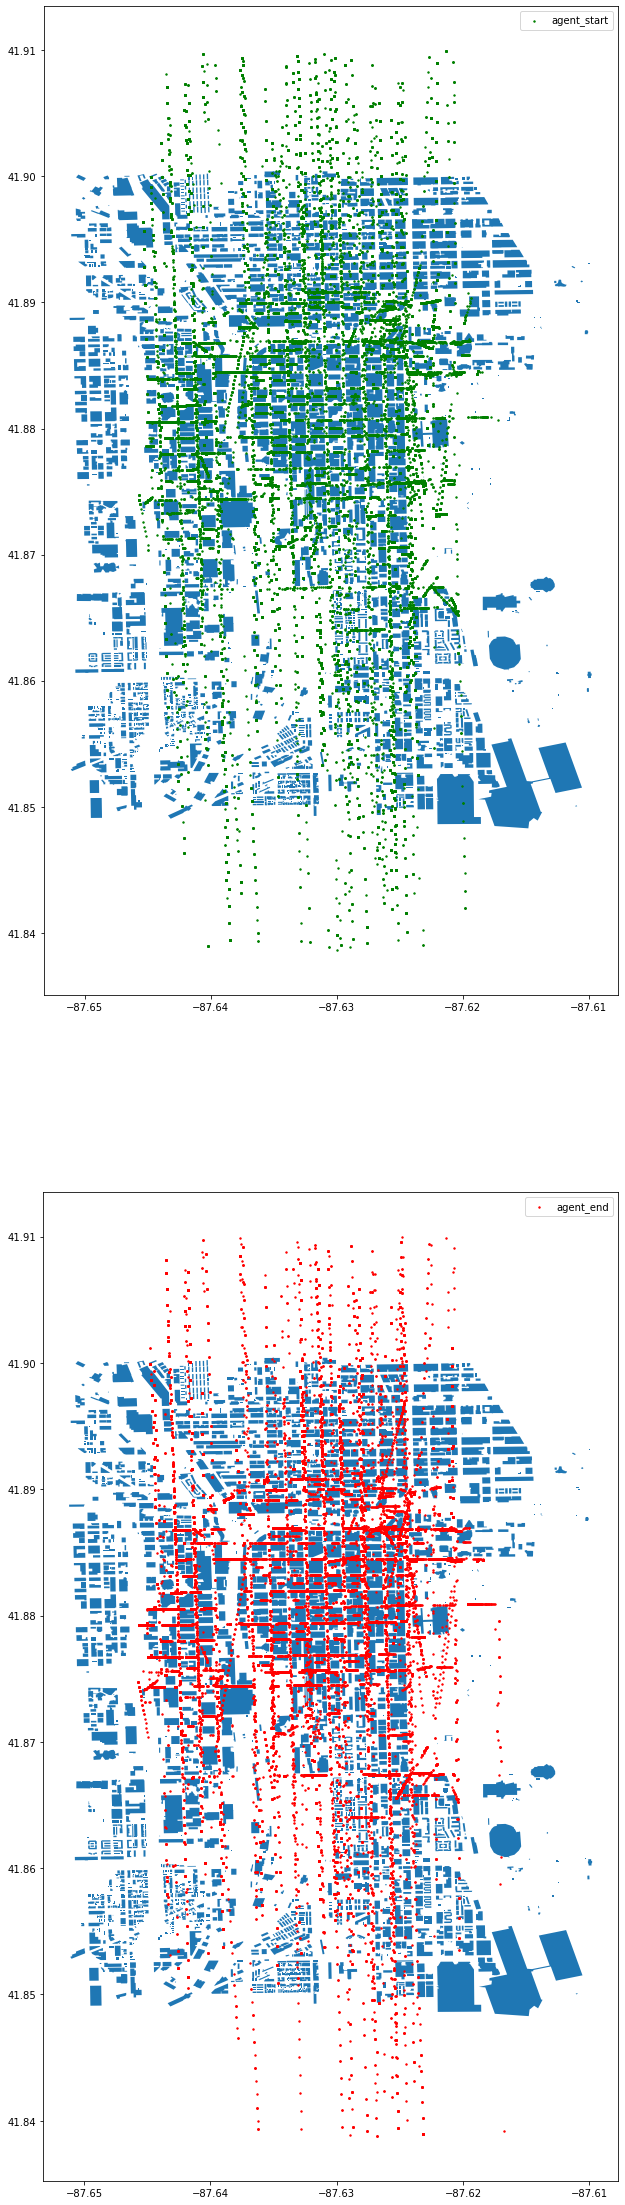

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,(ax1, ax2)= plt.subplots(2,figsize=(40,40))
# Plot buildings and start and  
building_map_proc.plot(ax=ax1)
building_map_proc.plot(ax=ax2)
sim_start_clip.plot(ax=ax1, marker='o', color='Green', markersize=2,label='agent_start')
sim_end_clip.plot(ax=ax2, marker='o', color='red', markersize=2,label='agent_end')
minx, miny, maxx, maxy = building_map.geometry.total_bounds
# # Margin around total bounds
ax.set_xlim(minx - 0.003, maxx + 0.003)
ax.set_ylim(miny - 0.003, maxy + 0.003)
ax1.legend(loc='best')
ax2.legend(loc='best')

In [181]:
from sklearn.neighbors import BallTree
import numpy as np

In [96]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=10, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [97]:
def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTE: Input points are in wgs84.
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.centroid

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
#     # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right_geom_col.apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [98]:
import time
start_time = time.time()
closest_buildings_start = nearest_neighbor(sim_start_clip, building_map_proc, return_dist=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.8496520519256592 seconds ---


In [86]:
import time
start_time = time.time()
closest_buildings_end = nearest_neighbor(sim_end_clip, building_map_proc, return_dist=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.929445743560791 seconds ---


In [99]:
# Rename the geometry of closest stops gdf so that we can easily identify
closest_buildings_start = closest_buildings_start.rename(columns={'centroid': 'closest_building_centroid'})
# #remove the 'geometry' polygon column
closest_buildings_st = closest_buildings_start.drop(columns=['geometry']) #polygon
closest_buildings_st
# closest_buildings=closest_buildings.drop(columns=['Unnamed: 0'])
# #Merge the datasets by index (for this, it is good to use '.join()' -function)
sim_start_join = sim_start_clip.join(closest_buildings_st)
sim_start_join

,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,...,X_COORD,Y_COORD,id,geometry,area,perimeter,closest_building_centroid,footprint_area,building_id,distance
0,245126,0:00:30,526,0,1,75.0,15.0,0.0,1,24512601,...,447472.067970,4.637343e+06,1,POINT (-87.63313 41.88627),2.395448e-07,0.002148,POINT (-87.63304 41.88608),2206.672016,1367,24.142541
1,166155,2:40,57,0,3,112.5,0.0,-30.0,1,16615501,...,447573.359857,4.636864e+06,1,POINT (-87.63187 41.88196),3.445150e-07,0.003200,POINT (-87.63186 41.88161),3173.876660,240,38.599655
2,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,...,446824.617870,4.636856e+06,1,POINT (-87.64089 41.88185),5.387833e-07,0.003316,POINT (-87.64046 41.88149),4963.606197,1541,62.581137
3,202723,2:47:30,139,1,3,67.5,7.5,-7.5,1,20272301,...,447741.477250,4.635920e+06,1,POINT (-87.62976 41.87347),1.016276e-07,0.001286,POINT (-87.62991 41.87336),936.371713,1224,21.380996
4,241483,2:47:30,527,0,1,120.0,7.5,7.5,1,24148301,...,447315.850742,4.637344e+06,1,POINT (-87.63502 41.88627),3.243570e-07,0.002472,POINT (-87.63507 41.88631),2987.959647,476,7.558522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103317,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,...,447608.505670,4.634674e+06,1,POINT (-87.63125 41.86224),1.222179e-08,0.000446,POINT (-87.63007 41.86207),112.630205,2229,132.444006
103318,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,...,447605.849683,4.634810e+06,1,POINT (-87.63130 41.86347),4.890239e-08,0.001000,POINT (-87.63005 41.86380),450.637826,1634,142.847138
103319,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,...,447600.676242,4.636580e+06,1,POINT (-87.63151 41.87941),3.031794e-07,0.002219,POINT (-87.63183 41.87909),2793.178419,2117,49.522618
103320,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,...,447603.193859,4.634946e+06,1,POINT (-87.63134 41.86469),1.591434e-08,0.000582,POINT (-87.63020 41.86528),146.646081,2328,142.428746


<IPython.core.display.Javascript object>


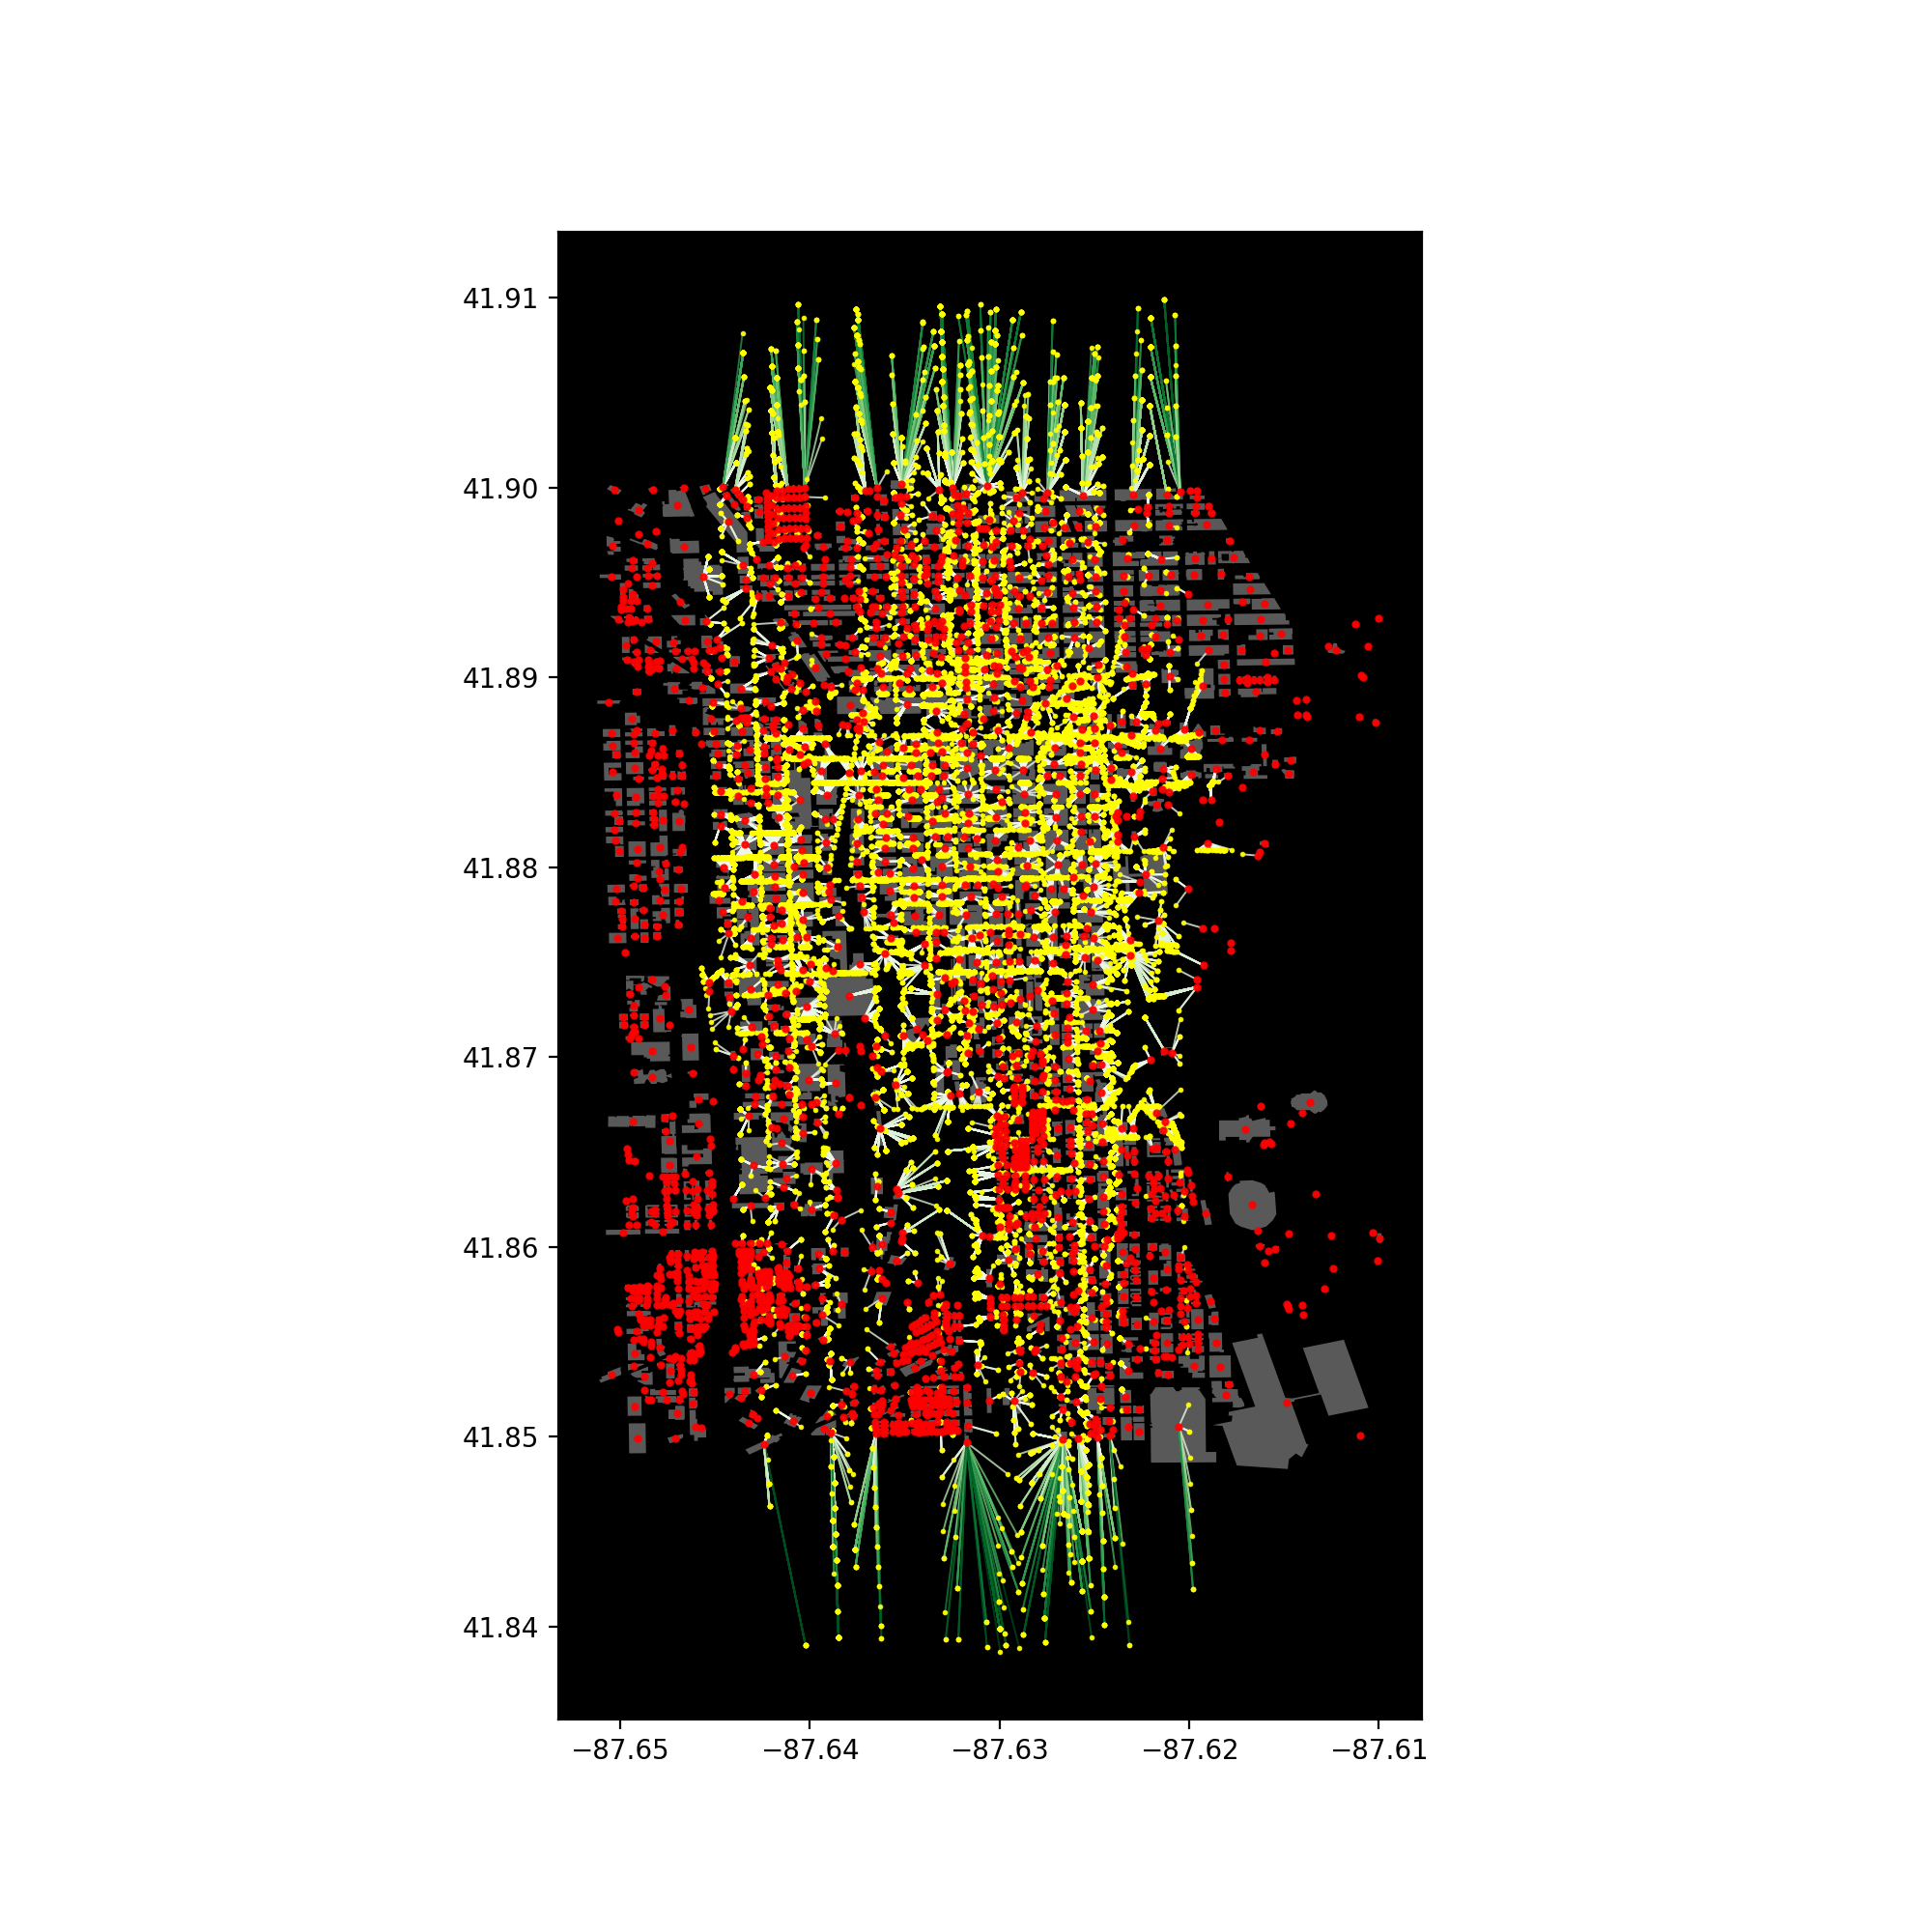

In [131]:
# Create a link (LineString) between building and stop points
sim_start_join['link'] =sim_start_join.apply(lambda row: LineString([row['geometry'], row['closest_building_centroid']]), axis=1)

# Set link as the active geometry
building_links = sim_start_join.copy()
building_links = building_links.set_geometry('link')
# building_links.groupby('building_id').count()
building_agents = building_links.groupby(['building_id','footprint_area']).count()
building_agents.drop(building_agents.columns.difference(['building_id','footprint_area','VEHICLE']), 1, inplace=True)
building_agents = building_agents.rename(columns={'VEHICLE':'count'})
building_agents_geom = building_agents.join(building_map_proc,on='building_id')

%matplotlib notebook

fig, ax= plt.subplots(figsize=(10,10))

ax = building_links.plot(ax=ax,column='distance', cmap='Greens', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = building_map_proc.plot(ax=ax, color='gray', markersize=1, alpha=0.7)
ax = sim_start_join.plot(ax=ax, markersize=1, marker='o', color='yellow', alpha=0.9, zorder=3)
ax = building_map_proc.centroid.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
#ax.set_xlim([24.99, 25.01])
#ax.set_ylim([])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

In [178]:
building_agents_geom



,,count,area,perimeter,geometry,centroid,footprint_area,building_id
building_id,footprint_area,,,,,,,
0,362.721327,1,3.938203e-08,0.000800,"POLYGON ((-87.64041 41.89671, -87.64023 41.896...",POINT (-87.64032 41.89682),362.721327,0
4,527.121386,115,5.721586e-08,0.000980,"POLYGON ((-87.64069 41.88016, -87.64099 41.880...",POINT (-87.64084 41.88006),527.121386,4
6,4019.585656,22,4.363114e-07,0.002883,"POLYGON ((-87.63936 41.88086, -87.63886 41.880...",POINT (-87.63914 41.88131),4019.585656,6
8,2250.526087,10,2.442998e-07,0.001982,"POLYGON ((-87.63264 41.88459, -87.63265 41.885...",POINT (-87.63291 41.88481),2250.526087,8
9,75.981718,2,8.245934e-09,0.000390,"POLYGON ((-87.62773 41.86897, -87.62767 41.868...",POINT (-87.62770 41.86903),75.981718,9
...,...,...,...,...,...,...,...,...
2426,3219.077663,64,3.493938e-07,0.003979,"POLYGON ((-87.62882 41.87587, -87.62886 41.876...",POINT (-87.62891 41.87650),3219.077663,2426
2428,315.558505,6,3.424293e-08,0.000761,"POLYGON ((-87.62755 41.86172, -87.62755 41.861...",POINT (-87.62762 41.86176),315.558505,2428
2430,455.785236,254,4.945309e-08,0.000934,"POLYGON ((-87.63901 41.85412, -87.63900 41.853...",POINT (-87.63891 41.85398),455.785236,2430


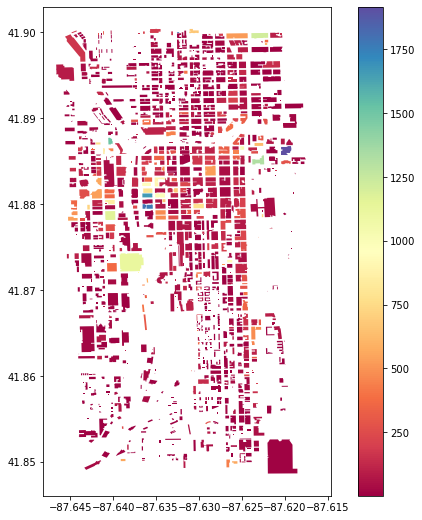

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
fig,ax = plt.subplots(figsize=(10,9))
building_agents_geom.reset_index(drop=True)
building_agents_geom = gpd.GeoDataFrame(building_agents_geom)
building_agents_geom.crs="EPSG:4326"
building_agents_geom.plot(ax=ax,column='count', cmap='Spectral',legend=True)


,count,area,perimeter,geometry,centroid,footprint_area,building_id
0,1,3.938203e-08,0.000800,"POLYGON ((-87.64041 41.89671, -87.64023 41.896...",POINT (-87.64032 41.89682),362.721327,0
1,115,5.721586e-08,0.000980,"POLYGON ((-87.64069 41.88016, -87.64099 41.880...",POINT (-87.64084 41.88006),527.121386,4
2,22,4.363114e-07,0.002883,"POLYGON ((-87.63936 41.88086, -87.63886 41.880...",POINT (-87.63914 41.88131),4019.585656,6
3,10,2.442998e-07,0.001982,"POLYGON ((-87.63264 41.88459, -87.63265 41.885...",POINT (-87.63291 41.88481),2250.526087,8
4,2,8.245934e-09,0.000390,"POLYGON ((-87.62773 41.86897, -87.62767 41.868...",POINT (-87.62770 41.86903),75.981718,9
...,...,...,...,...,...,...,...
1165,64,3.493938e-07,0.003979,"POLYGON ((-87.62882 41.87587, -87.62886 41.876...",POINT (-87.62891 41.87650),3219.077663,2426
1166,6,3.424293e-08,0.000761,"POLYGON ((-87.62755 41.86172, -87.62755 41.861...",POINT (-87.62762 41.86176),315.558505,2428
1167,254,4.945309e-08,0.000934,"POLYGON ((-87.63901 41.85412, -87.63900 41.853...",POINT (-87.63891 41.85398),455.785236,2430
1168,2,2.206957e-08,0.000660,"POLYGON ((-87.62261 41.89897, -87.62278 41.898...",POINT (-87.62269 41.89890),203.262760,2435
